In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,export_graphviz
from DecisionTree import DecisionTree
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor
from GradientBoosting import GradientBoosting as myGB
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLDER = "data/"
FILES = [
        "iris.txt", "bezdekIris.txt", "wine.txt", "bupa.txt", "housing.txt", "auto-mpg.txt", "spam"
        ]
FILE = "spam"

In [3]:
# Подготавливаем признаки и целевую функцию
if FILE in FILES[:6]:
    
    df = pd.read_csv(FOLDER+FILE, sep=",", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
    
    if FILE in FILES[:2]:
        # ИРИСЫ
        df[4] = pd.factorize(df[4])[0]
        X = df[[0,1,2,3]].as_matrix()
        y = df[4].as_matrix()

    if FILE == FILES[2]:
        x_indexes = [x for x in range(1,14)]
        X = df[x_indexes].as_matrix()
        y = df[0].as_matrix()

    if FILE == FILES[3]:
        X = df[[0,1,2,3,4,5]].as_matrix()
        y = df[6]
        
    if FILE == FILES[4]:
        df = pd.read_csv(FOLDER+FILE, sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
        X = df[df.columns[1:]].as_matrix()
        y = df[df.columns[0]].as_matrix()
        
    if FILE == FILES[5]:
        df = pd.read_csv(FOLDER+FILE, sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
        X = df[df.columns[1:-1]].as_matrix()
        y = df[df.columns[0]].as_matrix()
        
    x_train, x_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25)

else:
    
    df_train = pd.read_csv(FOLDER+FILE+".train.txt", sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
    df_test = pd.read_csv(FOLDER+FILE+".test.txt", sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
    x_train = df_train[df_train.columns[1:]].as_matrix()
    y_train = df_train[df_train.columns[0]].as_matrix()
    x_test = df_test[df_test.columns[1:]].as_matrix()
    y_test = df_test[df_test.columns[0]].as_matrix()

# Дерево решений

### Классификация

In [ ]:
%%time
my_tree = DecisionTree(max_features=20, min_samples_leaf=2, max_steps=None, rsm=True, max_depth=5)
my_tree.fit(x_train, y_train)
y_predicted = my_tree.predict(x_test)
print accuracy_score(y_test, y_predicted)

In [ ]:
%%time
sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(x_train, y_train)
y_predicted = sklearn_tree.predict(x_test)
print accuracy_score(y_test, y_predicted)

### Регрессия

In [4]:
%%time
my_tree = DecisionTree(is_classification=False, rsm=False, max_depth=None, min_samples_leaf=5000)
my_tree.fit(x_train, y_train)
y_predicted = my_tree.predict(x_test)
print mse(y_test, y_predicted)

0.140962063461
CPU times: user 27.7 s, sys: 107 ms, total: 27.8 s
Wall time: 27.7 s


In [14]:
%%time
sklearn_tree = DecisionTreeRegressor(splitter='best', max_depth=3, max_features=len(x_train[0]))
sklearn_tree.fit(x_train, y_train)
y_predicted = sklearn_tree.predict(x_test)
print mse(y_test, y_predicted)

0.158618363856
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 108 ms


In [ ]:
for i in range(len(x_train)):
    if not my_tree.predict([x_test[i]])[0] == sklearn_tree.predict([x_test[i]])[0]:
        print i, my_tree.predict([x_test[i]])[0], sklearn_tree.predict([x_test[i]])[0]

In [ ]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [ ]:
visualize_tree(sklearn_tree, range(0,102))

# Градиентный бустинг

### Регрессия

График зависимости качества классификации от минимального размера листа.

In [ ]:
def abs_loss(y_test, y_predicted):
    return sum(np.absolute(y_test - y_predicted))

In [18]:
n_est=250
max_depth=4
rsm=False
max_features=45
min_features=20
shrinkage=0.1

In [19]:
%%time
my_gb = myGB(n_estimators=n_est, max_depth=max_depth, max_features=max_features,\
             min_features=min_features, rsm=rsm, shrinkage=shrinkage)
my_gb.fit(x_train, y_train)
y_predict = my_gb.predict(x_test)
print mse(y_test, y_predict)

0.064515753859
CPU times: user 1h 1min 25s, sys: 10.1 s, total: 1h 1min 35s
Wall time: 1h 1min 34s


In [21]:
%%time
gb = GradientBoostingRegressor(n_estimators=n_est, max_depth=max_depth, learning_rate=shrinkage, min_samples_leaf=1)
gb.fit(x_train, y_train)
y_predicted = gb.predict(x_test)
print mse(y_test, y_predicted)

0.0681563053719
CPU times: user 19.9 s, sys: 15.9 ms, total: 19.9 s
Wall time: 19.9 s


In [22]:
STEP_LENGTH = 10
mse_array_my_train = np.zeros(n_est/STEP_LENGTH)
mse_array_sklearn_train = np.zeros(n_est/STEP_LENGTH)

mse_array_my_test = np.zeros(n_est/STEP_LENGTH)
mse_array_sklearn_test = np.zeros(n_est/STEP_LENGTH)

n_est_array = [i*10+1 for i in range(len(mse_array_my_train))]
for i in range(len(n_est_array)):
    est = n_est_array[i]
    
    # для моего бустинга
    #==========================
    # для тренировочной выборки
    y_predict = my_gb.predict_n(x_train, est)
    mse_array_my_train[i] = mse(y_train, y_predict)
    # для тестовой выборки
    y_predict = my_gb.predict_n(x_test, est)
    mse_array_my_test[i] = mse(y_test, y_predict)
    
    
    # для sklernoвского бустинга
    gb = GradientBoostingRegressor(n_estimators=est, max_depth=max_depth, learning_rate=shrinkage)
    gb.fit(x_train, y_train)
    # для тренировочной выборки
    y_predict = gb.predict(x_train)
    mse_array_sklearn_train[i] = mse(y_train, y_predict)
    # для тестовой выборки
    y_predict = gb.predict(x_test)
    mse_array_sklearn_test[i] = mse(y_test, y_predict)
    
    if rand() < 0.2:
        print "{} уже посчитано".format(est)

11 уже посчитано
31 уже посчитано
91 уже посчитано
141 уже посчитано
201 уже посчитано


In [23]:
def plot_curve(x, y_my, y_sklearn, title):
    
    fig = plt.figure(figsize=(15, 15))
    plt.plot(x, y_my, color='blue', label='MyGB')
    plt.plot(x, y_sklearn, '-,', color='green', label='SklearnGB')
    plt.plot(x, y_sklearn*1.03, '--', color='red', label='SklearnGB +3%')
    plt.plot(x, y_sklearn*0.97, '--', color='red', label='SklearnGB -3%')
    plt.ylim(0, max(y_sklearn*1.03)+0.02)
    plt.grid(True)
    plt.xlabel("n_estimators", fontsize=15)
    plt.ylabel("mse", fontsize=15)
    plt.title(title)
    plt.legend()
    #plt.show()
    return

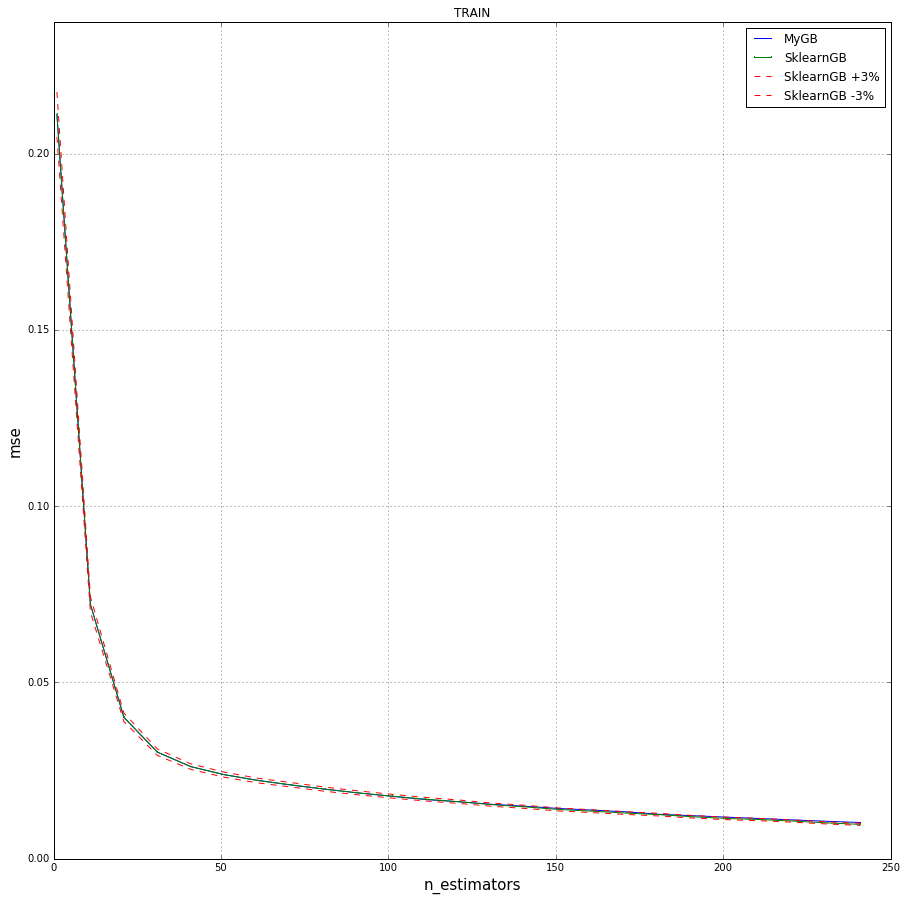

In [24]:
plot_curve(n_est_array, mse_array_my_train, mse_array_sklearn_train, "TRAIN");

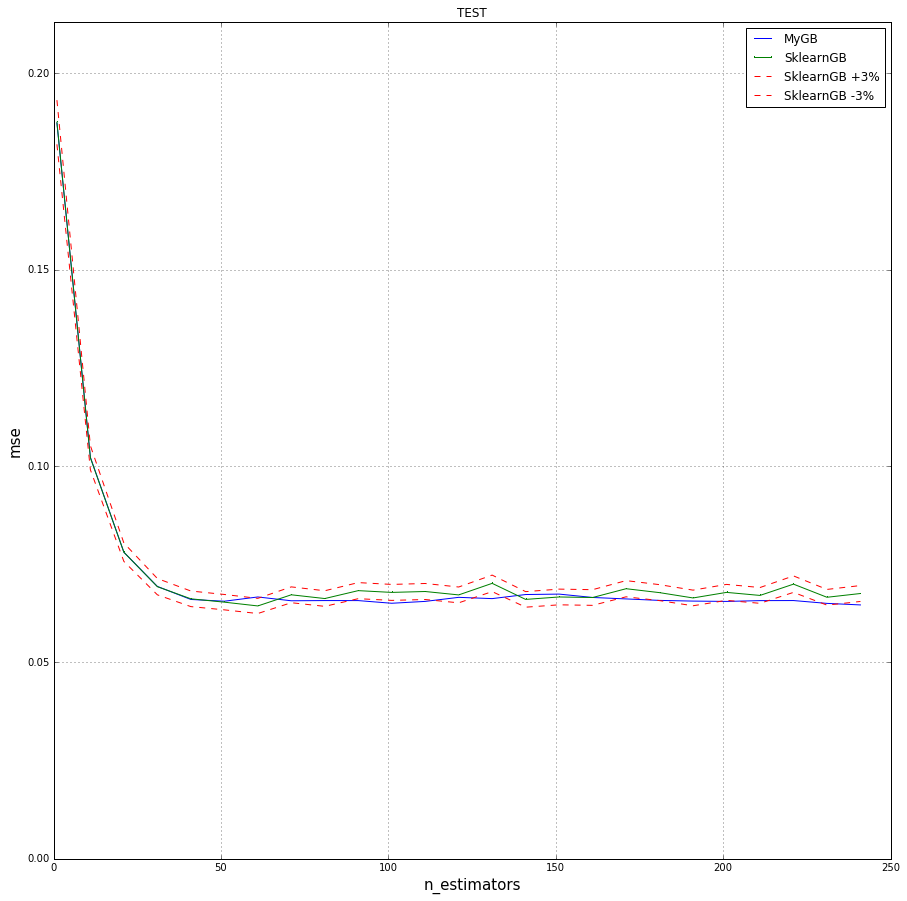

In [25]:
plot_curve(n_est_array, mse_array_my_test, mse_array_sklearn_test, "TEST")

In [26]:
%%time
my_gb = myGB(n_estimators=n_est, max_depth=max_depth, min_features=30, max_features=len(x_train[0]), rsm=True, shrinkage=shrinkage)
my_gb.fit(x_train, y_train)
y_predict = my_gb.predict(x_test)
print mse(y_test, y_predict)

0.0523466237369
CPU times: user 23min 33s, sys: 3.43 s, total: 23min 37s
Wall time: 23min 37s


In [27]:
STEP_LENGTH = 10
mse_array_my_train = np.zeros(n_est/STEP_LENGTH)
mse_array_sklearn_train = np.zeros(n_est/STEP_LENGTH)

mse_array_my_test = np.zeros(n_est/STEP_LENGTH)
mse_array_sklearn_test = np.zeros(n_est/STEP_LENGTH)

n_est_array = [i*10+1 for i in range(len(mse_array_my_train))]
for i in range(len(n_est_array)):
    est = n_est_array[i]
    
    # для моего бустинга
    #==========================
    # для тренировочной выборки
    y_predict = my_gb.predict_n(x_train, est)
    mse_array_my_train[i] = mse(y_train, y_predict)
    # для тестовой выборки
    y_predict = my_gb.predict_n(x_test, est)
    mse_array_my_test[i] = mse(y_test, y_predict)
    
    
    # для sklernoвского бустинга
    gb = GradientBoostingRegressor(n_estimators=est, max_depth=max_depth, learning_rate=shrinkage)
    gb.fit(x_train, y_train)
    # для тренировочной выборки
    y_predict = gb.predict(x_train)
    mse_array_sklearn_train[i] = mse(y_train, y_predict)
    # для тестовой выборки
    y_predict = gb.predict(x_test)
    mse_array_sklearn_test[i] = mse(y_test, y_predict)
    
    if rand() < 0.2:
        print "{} уже посчитано".format(est)

21 уже посчитано
51 уже посчитано
81 уже посчитано
91 уже посчитано
151 уже посчитано
171 уже посчитано


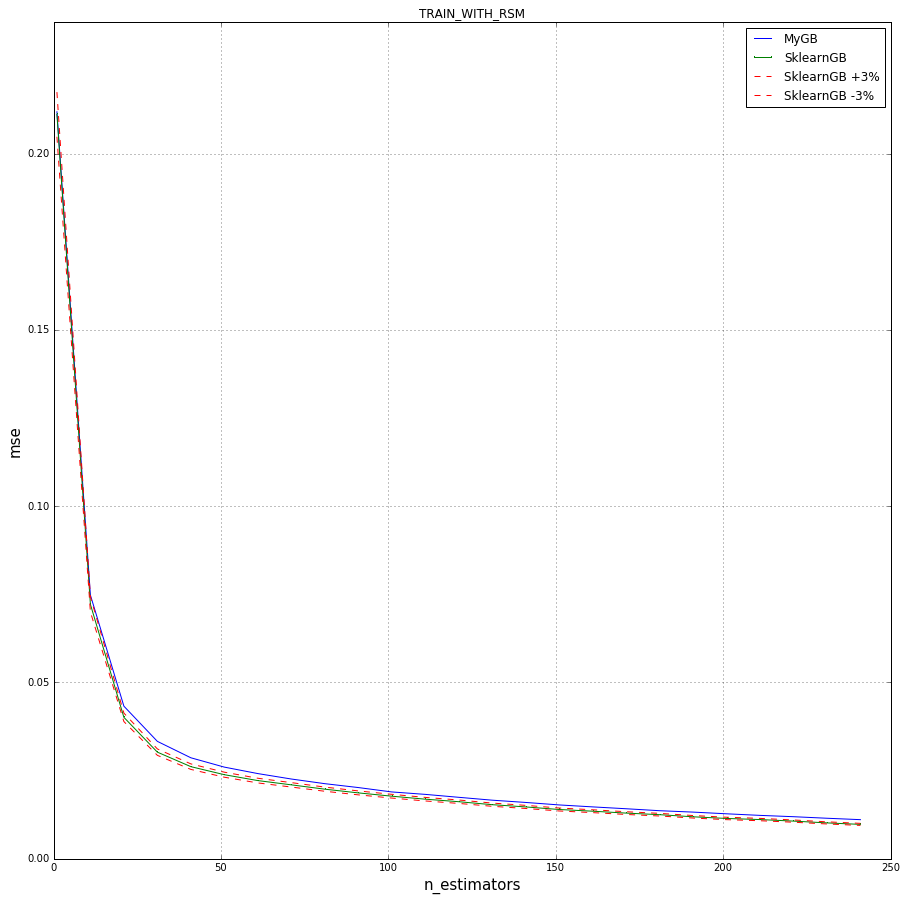

In [28]:
plot_curve(n_est_array, mse_array_my_train, mse_array_sklearn_train, "TRAIN_WITH_RSM");

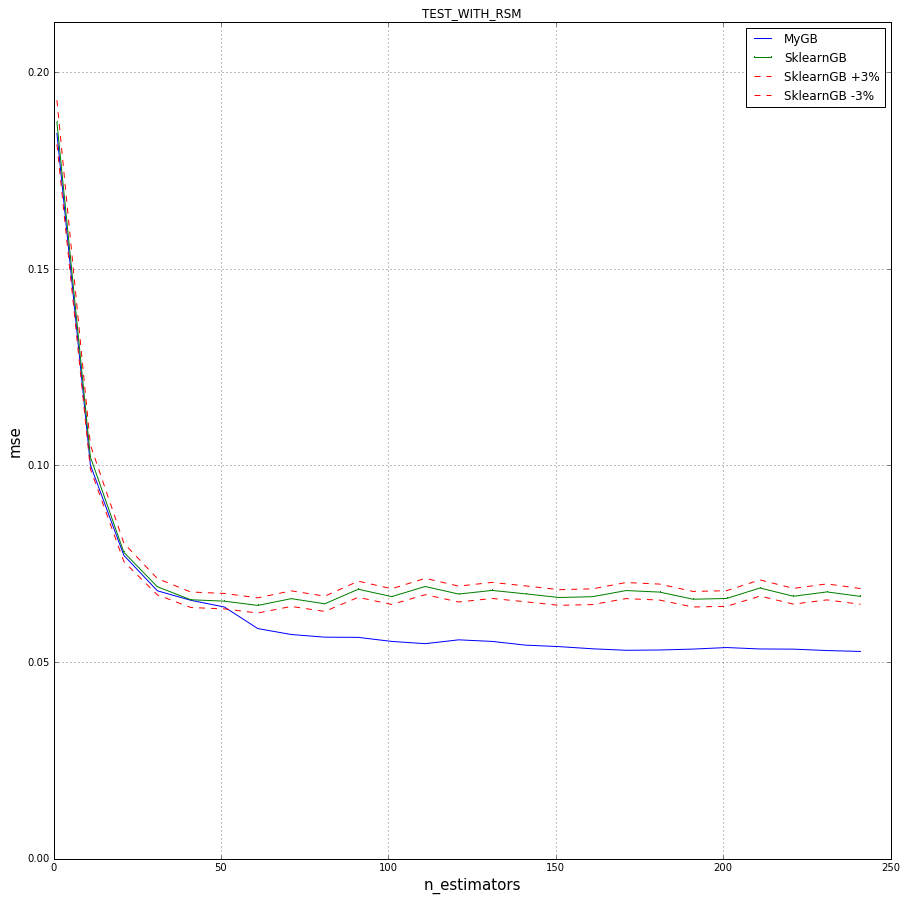

In [29]:
plot_curve(n_est_array, mse_array_my_test, mse_array_sklearn_test, "TEST_WITH_RSM")